In [ ]:
# load the libraries

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import LSTM, Embedding, Dense, Dropout, Input, SimpleRNN
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

In [ ]:
# Set some seeds for reproducibility
np.random.seed(123)
tf.random.set_seed(2)
tf.keras.utils.set_random_seed(10)
tf.config.experimental.enable_op_determinism()

In [ ]:
# Load the dataset

df = pd.read_csv("/content/McDonald_s_Reviews.csv", encoding='latin1')
print(df.info())
print(df.head(4))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33396 entries, 0 to 33395
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reviewer_id    33396 non-null  int64  
 1   store_name     33396 non-null  object 
 2   category       33396 non-null  object 
 3   store_address  33396 non-null  object 
 4   latitude       32736 non-null  float64
 5   longitude      32736 non-null  float64
 6   rating_count   33396 non-null  object 
 7   review_time    33396 non-null  object 
 8   review         33396 non-null  object 
 9   rating         33396 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 2.5+ MB
None
   reviewer_id  store_name              category  \
0            1  McDonald's  Fast food restaurant   
1            2  McDonald's  Fast food restaurant   
2            3  McDonald's  Fast food restaurant   
3            4  McDonald's  Fast food restaurant   

                                   

In [ ]:
# Discard the not necessary features

df = df[['review', 'rating']]
print(df.head(4))

                                              review   rating
0  Why does it look like someone spit on my food?...   1 star
1  It'd McDonalds. It is what it is as far as the...  4 stars
2  Made a mobile order got to the speaker and che...   1 star
3  My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...  5 stars


**General preprocessing**

In [ ]:
# Load preprocesing libraries

import nltk
from nltk.tokenize import word_tokenize,TweetTokenizer
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import string

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Text normalization (put all the words in lowercase)

review_list = [review.lower() for review in df["review"]]
print(review_list[:2])

['why does it look like someone spit on my food?\ni had a normal transaction,  everyone was chill and polite, but now i dont want to eat this. im trying not to think about what this milky white/clear substance is all over my food, i d*** sure am not coming back.', "it'd mcdonalds. it is what it is as far as the food and atmosphere go. the staff here does make a difference. they are all friendly, accommodating and always smiling. makes for a more pleasant experience than many other fast food places."]


In [ ]:
# Tokenization

rev_words = [word_tokenize(review) for review in review_list]
print(rev_words[:2])

[['why', 'does', 'it', 'look', 'like', 'someone', 'spit', 'on', 'my', 'food', '?', 'i', 'had', 'a', 'normal', 'transaction', ',', 'everyone', 'was', 'chill', 'and', 'polite', ',', 'but', 'now', 'i', 'dont', 'want', 'to', 'eat', 'this', '.', 'im', 'trying', 'not', 'to', 'think', 'about', 'what', 'this', 'milky', 'white/clear', 'substance', 'is', 'all', 'over', 'my', 'food', ',', 'i', 'd', '*', '*', '*', 'sure', 'am', 'not', 'coming', 'back', '.'], ['it', "'d", 'mcdonalds', '.', 'it', 'is', 'what', 'it', 'is', 'as', 'far', 'as', 'the', 'food', 'and', 'atmosphere', 'go', '.', 'the', 'staff', 'here', 'does', 'make', 'a', 'difference', '.', 'they', 'are', 'all', 'friendly', ',', 'accommodating', 'and', 'always', 'smiling', '.', 'makes', 'for', 'a', 'more', 'pleasant', 'experience', 'than', 'many', 'other', 'fast', 'food', 'places', '.']]


In [ ]:
# Lemmatization

wnl = WordNetLemmatizer()
lemmatized_words =[]
for review in rev_words:
    lemma_word=[]
    for word in review:
        lemma_word.append(wnl.lemmatize(word))
    lemmatized_words.append(lemma_word)

print(lemmatized_words[:50])

[['why', 'doe', 'it', 'look', 'like', 'someone', 'spit', 'on', 'my', 'food', '?', 'i', 'had', 'a', 'normal', 'transaction', ',', 'everyone', 'wa', 'chill', 'and', 'polite', ',', 'but', 'now', 'i', 'dont', 'want', 'to', 'eat', 'this', '.', 'im', 'trying', 'not', 'to', 'think', 'about', 'what', 'this', 'milky', 'white/clear', 'substance', 'is', 'all', 'over', 'my', 'food', ',', 'i', 'd', '*', '*', '*', 'sure', 'am', 'not', 'coming', 'back', '.'], ['it', "'d", 'mcdonalds', '.', 'it', 'is', 'what', 'it', 'is', 'a', 'far', 'a', 'the', 'food', 'and', 'atmosphere', 'go', '.', 'the', 'staff', 'here', 'doe', 'make', 'a', 'difference', '.', 'they', 'are', 'all', 'friendly', ',', 'accommodating', 'and', 'always', 'smiling', '.', 'make', 'for', 'a', 'more', 'pleasant', 'experience', 'than', 'many', 'other', 'fast', 'food', 'place', '.'], ['made', 'a', 'mobile', 'order', 'got', 'to', 'the', 'speaker', 'and', 'checked', 'it', 'in', '.', 'line', 'wa', 'not', 'moving', 'so', 'i', 'had', 'to', 'leave',

In [ ]:
# Create list of stopwords, punctuations and other characters to eliminate

stop_words = set(stopwords.words("english"))
toRemove = list(stop_words) + list(string.punctuation) + ["\'s", "½", "ï", "¿", '...', '..']

tweet_tokenize = TweetTokenizer()
preprocessed_reviews = []

for review in lemmatized_words:
    filter_words=[]
    for words in review:
        rev_words = []
        rev_words = tweet_tokenize.tokenize(words)
        for word in rev_words:
            if word not in toRemove:
                filter_words.append(word)
    preprocessed_reviews.append(filter_words)

print('number of reviews:', len(preprocessed_reviews))
print("let's see some reviews:", preprocessed_reviews[:2])

number of reviews: 33396
let's see some reviews: [['doe', 'look', 'like', 'someone', 'spit', 'food', 'normal', 'transaction', 'everyone', 'wa', 'chill', 'polite', 'dont', 'want', 'eat', 'im', 'trying', 'think', 'milky', 'white', 'clear', 'substance', 'food', 'sure', 'coming', 'back'], ['mcdonalds', 'far', 'food', 'atmosphere', 'go', 'staff', 'doe', 'make', 'difference', 'friendly', 'accommodating', 'always', 'smiling', 'make', 'pleasant', 'experience', 'many', 'fast', 'food', 'place']]


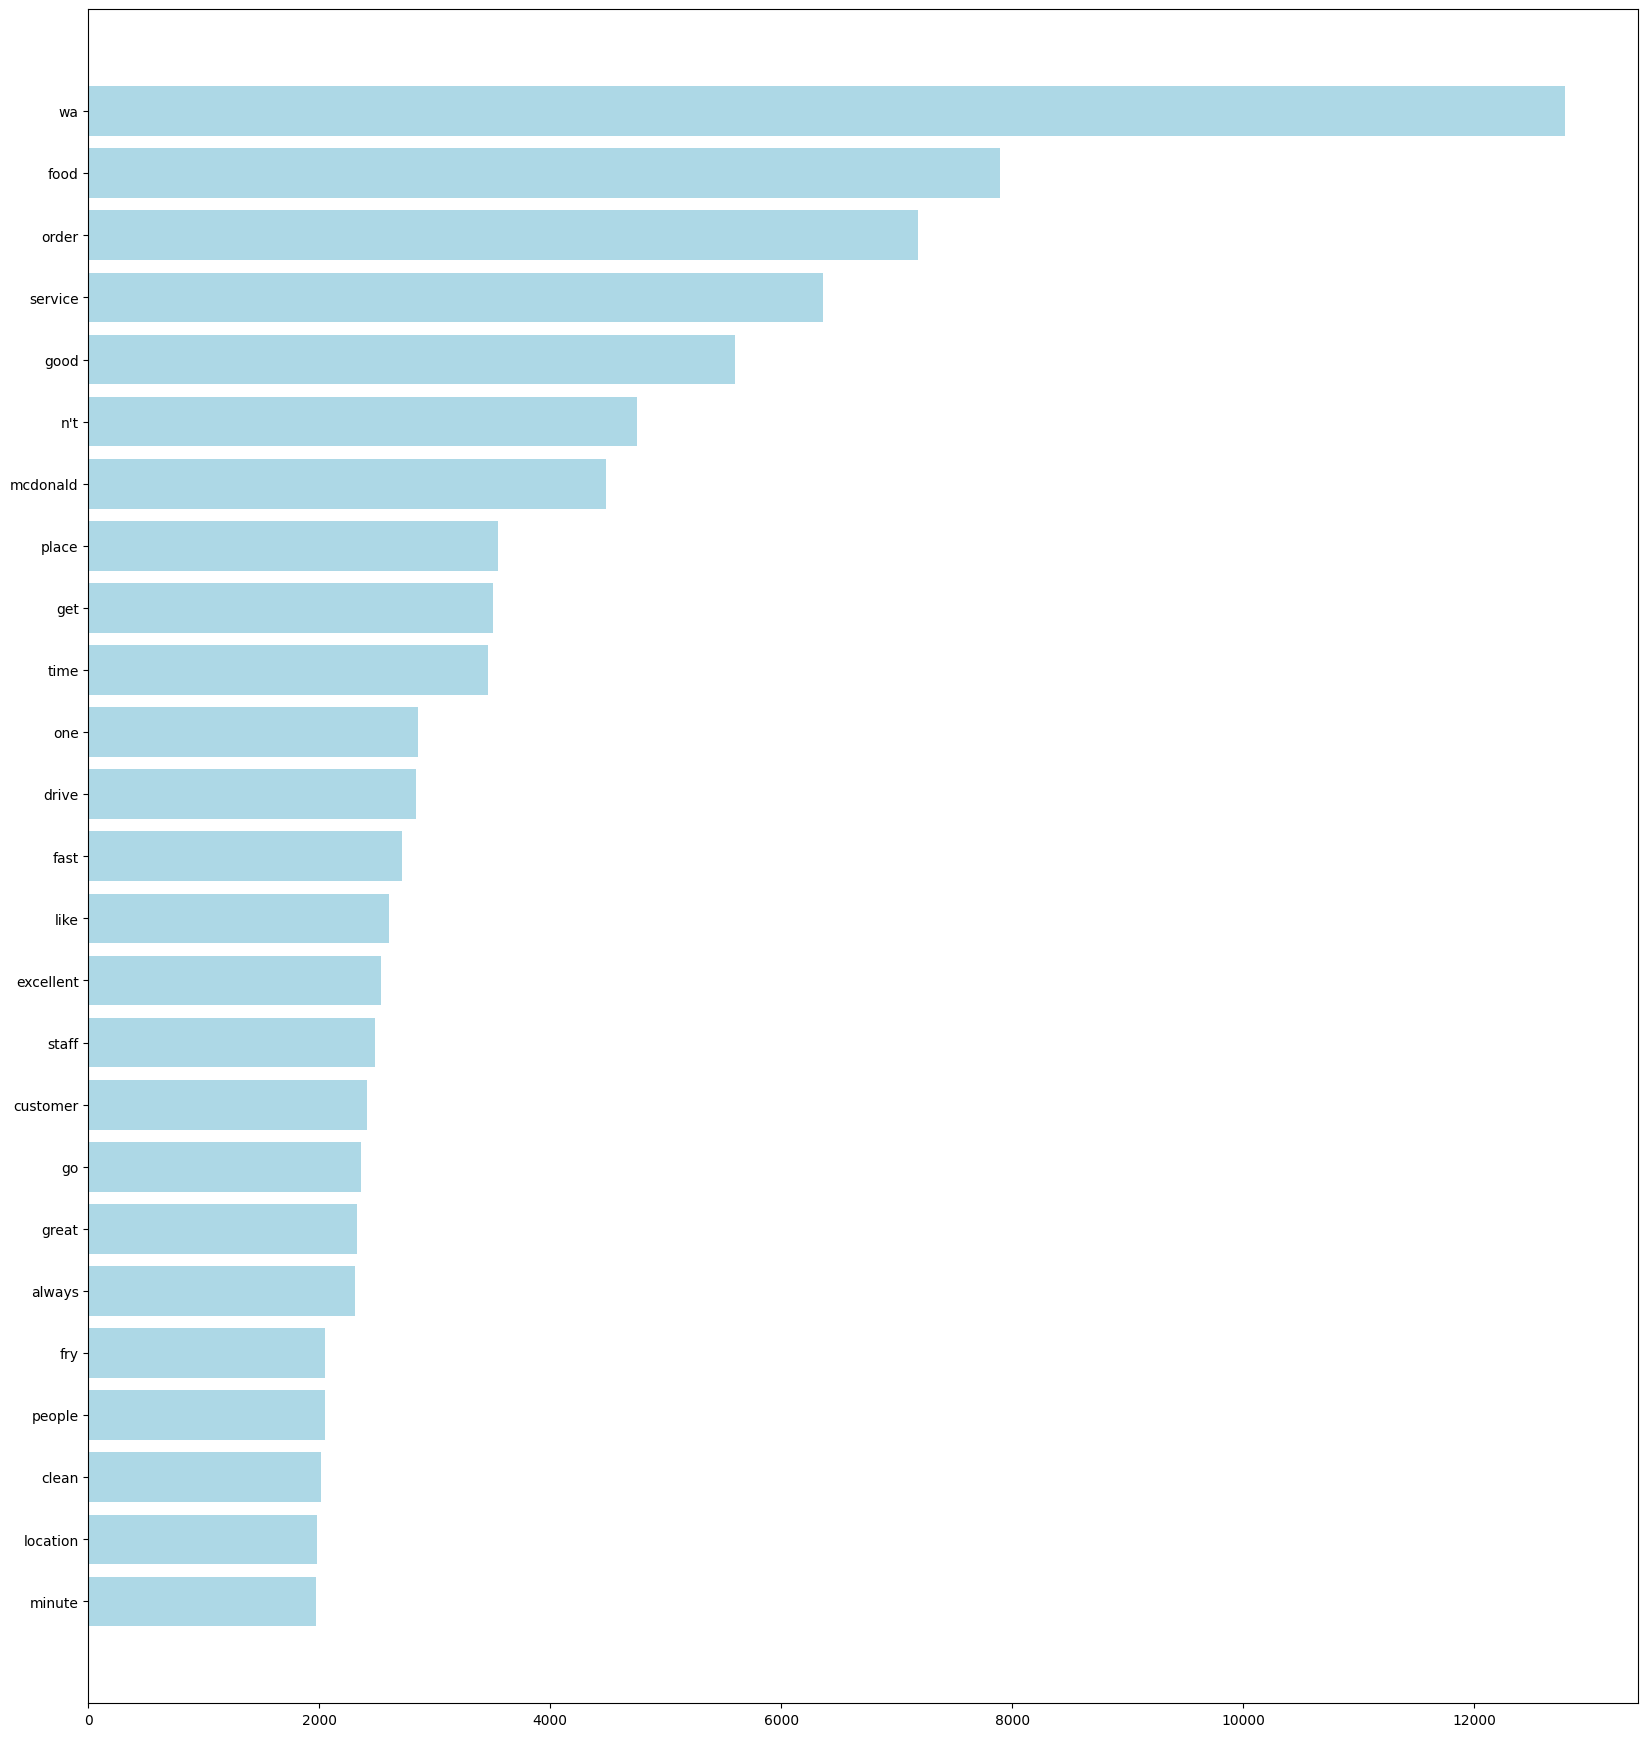

In [ ]:
# Barplot to visualize the 25 most common words using FreqDist and barplots

list_of_words = [word for review in preprocessed_reviews for word in review]
common_word_freq=FreqDist(list_of_words).most_common(25)
word_list = common_word_freq[::-1]

words,freq = [],[]
for word in word_list:
    words.append(word[0])
    freq.append(word[1])
x=np.array(words)
y=np.array(freq)

plt.figure(figsize=(20,22))
plt.barh(x,y,color="lightblue")
plt.show()

**Preprocessing for sentiment analysis**

In [ ]:
# Ratings frequency tabl
df.rating.value_counts()

,count
rating,
5 stars,10274
1 star,9431
4 stars,5787
3 stars,4818
2 stars,3086


In [ ]:
# Let's transform the rating value in integer

def rating_to_numeric(rate_string):
    return int(rate_string[0])

df.loc[:,"rating"] = df.rating.map(lambda x: rating_to_numeric(x))

In [ ]:
# Create the column "sentiment", which is 'positive' for positive ratings (4 and 5),
# 'negative' for negative ratings (1 and 2) and 'neutral' for neutral ratings (0)

def createSentiment(rating):
    if rating > 3:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

# Create a new column 'sentiment'
df["sentiment"] = np.zeros(df.shape[0])
df.loc[:,'sentiment'] = df.loc[:,'rating'].apply(createSentiment)

In [ ]:
# Sentiments frequency table
df.sentiment.value_counts()

,count
sentiment,
positive,16061
negative,12517
neutral,4818


**Preprocessing for RNN models**

In [ ]:
# Convert sequences of tokens to sequences of integers for the RNN model

tokenizer = Tokenizer(num_words=4000, oov_token='<OOV>')    # words out of the vocabulary are set as 'OOV'
tokenizer.fit_on_texts(preprocessed_reviews)

sequences = tokenizer.texts_to_sequences(preprocessed_reviews)

print(sequences[:2])

[[155, 170, 15, 207, 1912, 3, 478, 1732, 264, 2, 2049, 398, 249, 99, 63, 531, 341, 197, 3162, 731, 1010, 1, 3, 183, 255, 34], [35, 270, 3, 526, 19, 17, 155, 73, 986, 38, 1315, 21, 1405, 73, 452, 70, 154, 14, 3, 9]]


In [ ]:
maxSeqLength = np.max(list(map(lambda x: len(x), preprocessed_reviews)))
print('length of the longest review:', maxSeqLength)

length of the longest review: 282


In [ ]:
# Sequence Padding: RNN networks require input data with the same length, we used padding
# to ensure all sequences had the same length.

X = pad_sequences(sequences, maxlen=maxSeqLength)
print(X[:2])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0   

In [ ]:
# We convert our sentiment labels (positive, neutral, negative) into numerical format:
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
y = df['sentiment'].map(label_mapping)

In [ ]:
# Split the dataset X,y into train and test set

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print('data shapes:')
print('x train', x_train.shape)
print('y train', y_train.shape)
print('x test', x_test.shape)
print('y test', y_test.shape)

data shapes:
x train (23377, 282)
y train (23377,)
x test (10019, 282)
y test (10019,)


In [ ]:
# Put the vectors of labels y_train and y_test into one-hot encoding format for RNN model

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print('One-hot target labels:', y_train)

One-hot target labels: [[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


**Simple RNN**

In [ ]:
# Parameters of the models
numClasses = len(y_train[0])   # 3 classes (positive, negative, neutral)
vocabularySize = len(tokenizer.word_index) + 1       # size of the vocabulary: the total number of unique words (tot words + space for unknown words)
d_model = 15  # Dimension of the embedding output

In [ ]:
# Simple RNN model definition

input_layer = Input(shape=(maxSeqLength,))
embedding_layer = Embedding(input_dim=vocabularySize, output_dim=d_model, input_length=maxSeqLength)(input_layer)
rnn_layer1 = SimpleRNN(64, activation='tanh', recurrent_dropout=0.3, return_sequences=True)(embedding_layer)
dropout_layer1 = Dropout(0.4)(rnn_layer1)
rnn_layer2 = SimpleRNN(32, activation='tanh', recurrent_dropout=0.3)(dropout_layer1)
dropout_layer2 = Dropout(0.3)(rnn_layer2)
dense_layer = Dense(8, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dropout_layer2)
output_layer = Dense(numClasses, activation='softmax')(dense_layer)


rnn = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
rnn.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-2),
              metrics=['accuracy'])

print(rnn.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 282)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 282, 15)             │         208,185 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 282, 64)             │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 282, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 32)                  │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 216,700 (846.48 KB)

 Trainable params: 216,700 (846.48 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Create early stopping object
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=4, verbose=1, mode='auto')

# Train the model
rnn_history = rnn.fit(x_train, y_train, epochs=40, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 43s 264ms/step - accuracy: 0.4621 - loss: 1.0632 - val_accuracy: 0.4803 - val_loss: 1.0086
Epoch 2/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 44s 286ms/step - accuracy: 0.4739 - loss: 1.0066 - val_accuracy: 0.4803 - val_loss: 1.0061
Epoch 3/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 78s 257ms/step - accuracy: 0.4764 - loss: 1.0033 - val_accuracy: 0.5148 - val_loss: 0.9417
Epoch 4/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 263ms/step - accuracy: 0.5188 - loss: 0.9477 - val_accuracy: 0.6249 - val_loss: 0.8278
Epoch 5/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 270ms/step - accuracy: 0.5983 - loss: 0.8726 - val_accuracy: 0.6916 - val_loss: 0.7552
Epoch 6/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 269ms/step - accuracy: 0.6488 - loss: 0.8238 - val_accuracy: 0.6846 - val_loss: 0.7595
Epoch 7/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 43s 290ms/step - accuracy: 0.6564 - loss: 0.8036 - val_accuracy: 0.7085 - val_loss: 0.7346
Epoch 8/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 283ms/step - accuracy: 0.6812 - loss: 0

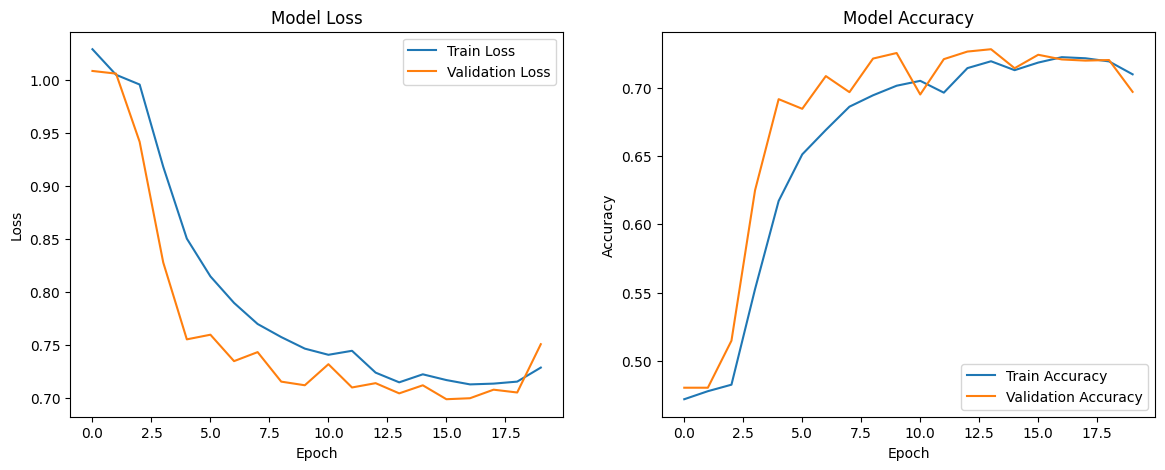

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# First plot: loss over epochs
ax[0].plot(rnn_history.history['loss'], label='Train Loss')
ax[0].plot(rnn_history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='upper right')

# # Second plot: accuracy over epochs
ax[1].plot(rnn_history.history['accuracy'], label='Train Accuracy')
ax[1].plot(rnn_history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='lower right')

plt.show()

In [ ]:
# Evaluate the model on test data

pred_rnn = rnn.predict(x_test)

# convert the predictions from one-hot encoding into classic integer encoding (negative=0, neutral=1, positive=2)
pred_rnn = np.argmax(pred_rnn, axis=1)
true_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(true_classes, pred_rnn)
precision = precision_score(true_classes, pred_rnn, average='weighted', zero_division=0)
recall = recall_score(true_classes, pred_rnn, average='weighted', zero_division=0)
f1 = f1_score(true_classes, pred_rnn, average='weighted')
conf_matrix = confusion_matrix(true_classes, pred_rnn)

print("Model Accuracy: %.2f%%" % (accuracy * 100))
print("Precision: %.2f" % precision)
print("Recall: %.2f" % recall)
print("F1 Score: %.2f" % f1)

314/314 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step
Model Accuracy: 70.28%
Precision: 0.74
Recall: 0.70
F1 Score: 0.68


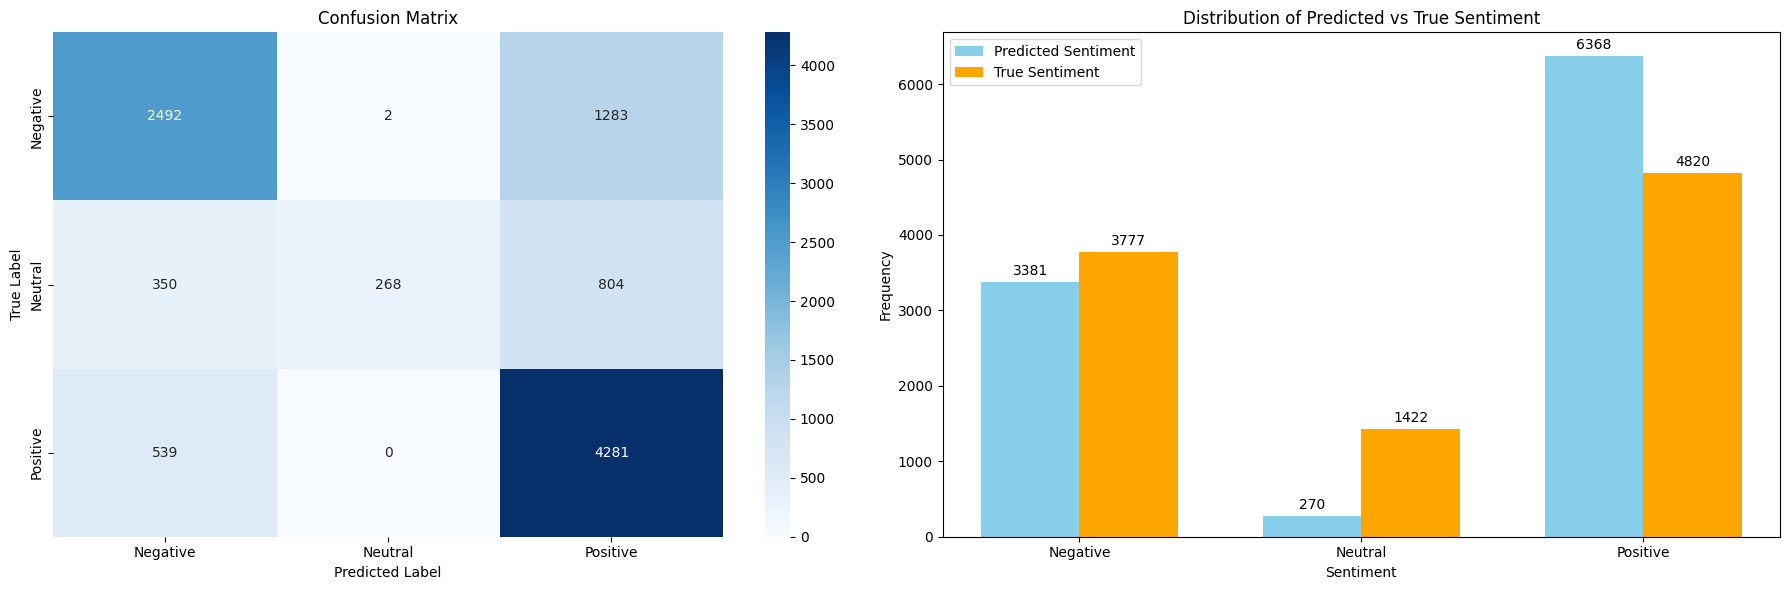

In [ ]:
# Model prediction frequences
pred_unique, pred_counts = np.unique(pred_rnn, return_counts=True)
pred_class_distribution = dict(zip(pred_unique, pred_counts))

# True sentiment frequences
true_unique, true_counts = np.unique(true_classes, return_counts=True)
true_class_distribution = dict(zip(true_unique, true_counts))

class_labels = ['Negative', 'Neutral', 'Positive']
n_classes = len(class_labels)

pred_freq = [pred_class_distribution.get(i, 0) for i in range(n_classes)]
true_freq = [true_class_distribution.get(i, 0) for i in range(n_classes)]

# Create the bars
x = np.arange(n_classes)
width = 0.35


fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Confusion matrix plot
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels, ax=axes[0])

axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix')

# Plot of the distribution of true and predicted sentiment
bars1 = axes[1].bar(x - width/2, pred_freq, width, label='Predicted Sentiment', color='skyblue')
bars2 = axes[1].bar(x + width/2, true_freq, width, label='True Sentiment', color='orange')

axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Predicted vs True Sentiment')
axes[1].set_xticks(x)
axes[1].set_xticklabels(class_labels)
axes[1].legend()

# labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        axes[1].annotate('{}'.format(height),
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),  # 3 points vertical offset
                         textcoords="offset points",
                         ha='center', va='bottom')
add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()

**LSTM model**

In [ ]:
# LSTM
# Model definition

input_layer = Input(shape=(maxSeqLength,))
embedding_layer = Embedding(input_dim=vocabularySize, output_dim=d_model, input_length=maxSeqLength)(input_layer)
lstm_layer1 = LSTM(64, activation='tanh', recurrent_dropout=0.3, return_sequences=True)(embedding_layer)
dropout_layer1 = Dropout(0.4)(lstm_layer1)
lstm_layer2 = LSTM(32, activation='tanh', recurrent_dropout=0.3)(dropout_layer1)
dropout_layer2 = Dropout(0.3)(lstm_layer2)
dense_layer = Dense(8, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dropout_layer2)
output_layer = Dense(numClasses, activation='softmax')(dense_layer)

lstm = Model(inputs=input_layer, outputs=output_layer)


# Compile the model
lstm.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])
print(lstm.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 282)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 282, 15)             │         208,185 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 282, 64)             │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 282, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 241,372 (942.86 KB)

 Trainable params: 241,372 (942.86 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Create early stopping object
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=3, verbose=1, mode='auto')

# Train the model
lstm_history = lstm.fit(x_train, y_train, epochs=40, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 106s 690ms/step - accuracy: 0.4814 - loss: 1.0588 - val_accuracy: 0.4803 - val_loss: 0.9984
Epoch 2/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 103s 701ms/step - accuracy: 0.4986 - loss: 1.0035 - val_accuracy: 0.5984 - val_loss: 0.9646
Epoch 3/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 99s 676ms/step - accuracy: 0.5883 - loss: 0.9675 - val_accuracy: 0.6106 - val_loss: 0.9142
Epoch 4/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 105s 714ms/step - accuracy: 0.6116 - loss: 0.9207 - val_accuracy: 0.6320 - val_loss: 0.8760
Epoch 5/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 100s 683ms/step - accuracy: 0.6419 - loss: 0.8796 - val_accuracy: 0.6822 - val_loss: 0.7935
Epoch 6/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 144s 697ms/step - accuracy: 0.6985 - loss: 0.7881 - val_accuracy: 0.7224 - val_loss: 0.7032
Epoch 7/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 100s 681ms/step - accuracy: 0.7338 - loss: 0.7119 - val_accuracy: 0.7545 - val_loss: 0.6620
Epoch 8/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 102s 693ms/step - accuracy: 0.7521 - 

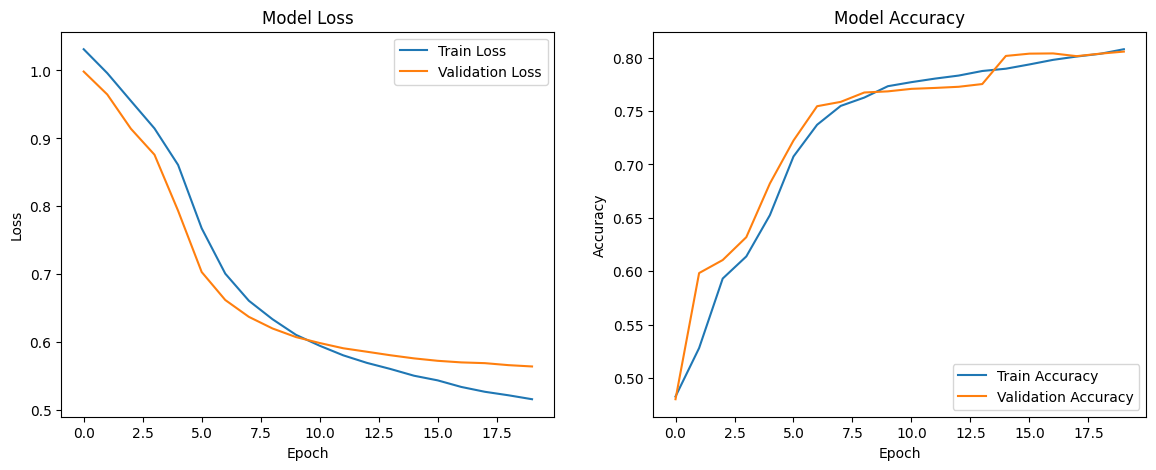

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# First plot: loss over epochs
ax[0].plot(lstm_history.history['loss'], label='Train Loss')
ax[0].plot(lstm_history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='upper right')

# # Second plot: accuracy over epochs
ax[1].plot(lstm_history.history['accuracy'], label='Train Accuracy')
ax[1].plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='lower right')

plt.show()

In [ ]:
# Evaluate the model on test data

pred_lstm = lstm.predict(x_test)

# convert the predictions from one-hot encoding into classic integer encoding (negative=0, neutral=1, positive=2)
pred_lstm = np.argmax(pred_lstm, axis=1)
true_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(true_classes, pred_lstm)
precision = precision_score(true_classes, pred_lstm, average='weighted')
recall = recall_score(true_classes, pred_lstm, average='weighted')
f1 = f1_score(true_classes, pred_lstm, average='weighted')
conf_matrix = confusion_matrix(true_classes, pred_lstm)

print("Model Accuracy: %.2f%%" % (accuracy * 100))
print("Precision: %.2f" % precision)
print("Recall: %.2f" % recall)
print("F1 Score: %.2f" % f1)

314/314 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step
Model Accuracy: 80.11%
Precision: 0.81
Recall: 0.80
F1 Score: 0.77


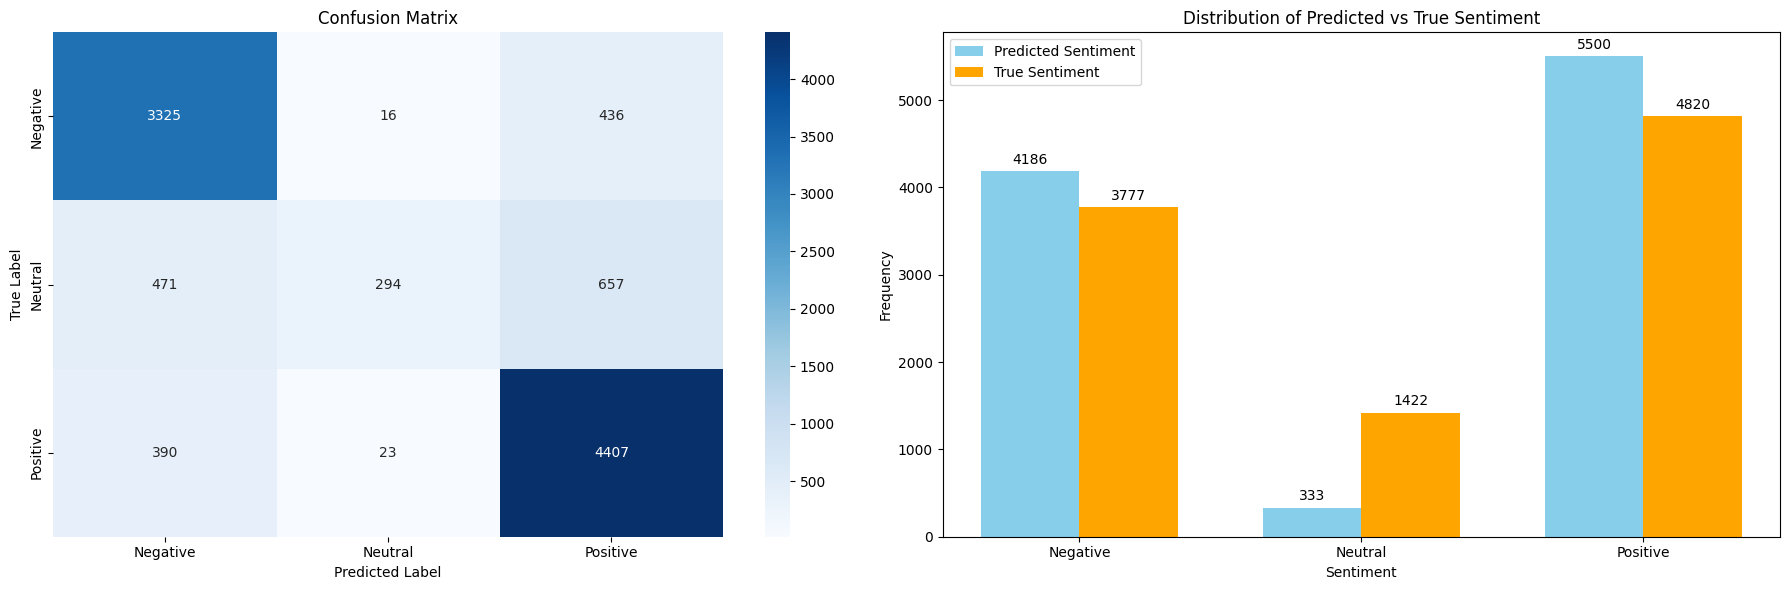

In [ ]:
# Model prediction frequences
pred_unique, pred_counts = np.unique(pred_lstm, return_counts=True)
pred_class_distribution = dict(zip(pred_unique, pred_counts))

# True sentiment frequences
true_unique, true_counts = np.unique(true_classes, return_counts=True)
true_class_distribution = dict(zip(true_unique, true_counts))

class_labels = ['Negative', 'Neutral', 'Positive']
n_classes = len(class_labels)

pred_freq = [pred_class_distribution.get(i, 0) for i in range(n_classes)]
true_freq = [true_class_distribution.get(i, 0) for i in range(n_classes)]

# Create the bars
x = np.arange(n_classes)
width = 0.35


fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Confusion matrix plot
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels, ax=axes[0])

axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix')

# Plot of the distribution of true and predicted sentiment
bars1 = axes[1].bar(x - width/2, pred_freq, width, label='Predicted Sentiment', color='skyblue')
bars2 = axes[1].bar(x + width/2, true_freq, width, label='True Sentiment', color='orange')

axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Predicted vs True Sentiment')
axes[1].set_xticks(x)
axes[1].set_xticklabels(class_labels)
axes[1].legend()

# labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        axes[1].annotate('{}'.format(height),
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),  # 3 points vertical offset
                         textcoords="offset points",
                         ha='center', va='bottom')
add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()

We notice that the LSTM model not only produces better results in terms of evaluation metrics, but also guarantees a more stable training process with respect to the basic RNN model.

Now we want to extract from the model predictions **only the predicted negative reviews**, in order to performing a topic modelling on them and identify the main problems related to the MC Donalds fast food restaurant.

In [ ]:
# Extract from the test set only the negative predicted reviews

negative_review_indices = np.where(pred_lstm == 0)[0]
negative_rev_in_seq = x_test[negative_review_indices, :]  # Extract the negative reviews in sequence form

In [ ]:
# Convert sequences back to text
negative_rev_in_text = tokenizer.sequences_to_texts(negative_rev_in_seq)

# Control print
print("Negative reviews predicted by the model:")
for review in negative_rev_in_text[:2]:
    print(review)

Negative reviews predicted by the model:
<OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>

In [ ]:
# Since the sequences were padded to ensure that they have the same length, now all the 0's
# are returned as '<OVO>' which stands for "Out Of The Vocabulary". I now eliminate this terms

negative_rev_in_text = [review.replace('<OOV>', '').strip() for review in negative_rev_in_text]

print("Negative reviews predicted by the model:")
for review in negative_rev_in_text[:5]:
    print(review)

Negative reviews predicted by the model:
somehow forgot give u order big deal needed exercise apologize
went drive-through ordered double mac meal received single mac meal food wa cold drove away call back told meal wa wrong manager tell next visit receive complimentary order giving right order given money back gave mcdonald benefit benefit doubt 1st bad experience mcdonald last never visit mcdonald
terrible employee name  ha worse customer service ever order wa wrong still wa giving hard time fix bad service
closed supposed 24 hour
service wa slow 10 minute 1 egg mcmuffin apology long delay


In [ ]:
pred_negative_reviews = negative_rev_in_text
print('number of negative reviews available for LDA:', len(pred_negative_reviews))

number of negative reviews available for LDA: 4186


In [ ]:
# Export the list of predicted negative reviews as a csv file
from google.colab import files

df_negative_reviews = pd.DataFrame(pred_negative_reviews, columns=['Negative review'])
df_negative_reviews.to_csv('pred_negative_reviews.csv', index=False)

files.download('pred_negative_reviews.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>